# Visualize data from [`nwb-extensions/staged-extensions`](https://github.com/nwb-extensions/staged-extensions)

Please run the following in the root directory to get the data.

```shell
make get-staged-ndx-GH-PR
make get-staged-ndx-PR-files
```

The data file is `data/github/staged-ndx-GH-PR.json`.

The output figure files are `figures/staged-ndx-GH-PR*.svg`.

Notes: 

- The reason why `PR 45` appears twice with `ndx-holographic-stimulation` and `ndx-bipolar-referencing` (which is also in closed `PR 10`) is because this PR  contains both of these extensions, see: <https://github.com/nwb-extensions/staged-extensions/pull/45/files>
- `Draft` PRs will appear (currently `PR 45`) but are not annotated accordingly. Notes: 



# 1. Import & configure

In [1]:
import os
import glob
import re
import json
import numpy as np
import pandas as pd

import matplotlib.pyplot as plt
from matplotlib import rcParams
import seaborn as sns

if 'notebook' in os.getcwd():
    os.chdir('..')

In [2]:
rcParams['font.family'] = 'Fira Sans'
rcParams['font.size'] = 18
rcParams['axes.titlesize'] = 20
rcParams['axes.labelsize'] = 18
rcParams['axes.linewidth'] = 1.5
rcParams['lines.linewidth'] = 1.5
rcParams['lines.markersize'] = 20
rcParams['patch.linewidth'] = 1.5
rcParams['xtick.labelsize'] = 18
rcParams['ytick.labelsize'] = 18
rcParams['xtick.major.width'] = 2
rcParams['xtick.minor.width'] = 2
rcParams['ytick.major.width'] = 2
rcParams['ytick.minor.width'] = 2
rcParams['savefig.dpi'] = 300
rcParams['savefig.transparent'] = False
rcParams['savefig.facecolor'] = 'white'
rcParams['savefig.format'] = 'svg'
rcParams['savefig.pad_inches'] = 0.5
rcParams['savefig.bbox'] = 'tight'

In [3]:
# visualization ylim lowerbound
viz_start_point = pd.Timestamp('2019-01-01', tz='UTC')

# use this for open PR, aka end of month of current month
open_end_point = pd.Timestamp.now(tz='UTC') + pd.tseries.offsets.MonthEnd()

# visualization ylim upperbound, 1 year after
viz_end_point = open_end_point + pd.tseries.offsets.YearBegin()

## 2. Process Github API data

In [4]:
df_files = []
for f in glob.glob('data/github/*PR*files.json'):
    PR_ID = re.search('PR-(\d+)_files.json', f).groups()[0]
    df_files.append(
        pd.read_json(f)
        .assign(PR=int(PR_ID))
        .filter(['PR', 'filename', 'status'])
    )

df_files = (
    pd.concat(df_files, ignore_index=True)
    .query('status == "added"')
    .reset_index(drop=True)
)

df_files['extension'] = df_files['filename'].apply(
    lambda x: n.replace('_','-').lower()
        if (n:=x.split('/')[0]).startswith('ndx')
        else None
)
df_ndx = (
    df_files
    .filter(['PR', 'extension'])
    .dropna()
    .drop_duplicates()
    .sort_values(by='PR')
    .reset_index(drop=True)
)

In [5]:
df_ndx

PR                         extension
0    1                        ndx-speech
1    4                     ndx-miniscope
2    6             ndx-simulation-output
3    8                     ndx-miniscope
4    9                          ndx-ecog
5   10           ndx-bipolar-referencing
6   12                          ndx-fret
7   13                  ndx-icephys-meta
8   14               ndx-franklab-novela
9   15                          ndx-mies
10  17                        ndx-events
11  19       ndx-tan-lab-mesh-attributes
12  20                          ndx-nirs
13  21                          ndx-test
14  22                          ndx-test
15  27                  ndx-optogenetics
16  28                       ndx-extract
17  29                         ndx-sound
18  30  ndx-hierarchical-behavioral-data
19  31                          ndx-pose
20  32                    ndx-photometry
21  38           ndx-multichannel-volume
22  39            ndx-acquisition-module
23  40                 ndx-odor-metadata
24  41                ndx-probeinterface
25  42                         ndx-whisk
26  43                           ndx-ecg
27  44                     ndx-photostim
28  45           ndx-bipolar-referencing
29  45       ndx-holographic-stimulation
30  46                   ndx-depth-moseq
31  47                           ndx-dbs
32  48                           ndx-hed

In [6]:
df = pd.read_json('data/github/staged-ndx-GH-PR.json')
df['author'] = df['user'].apply(lambda x: x['login'])

columns = [
    'url', 'author', 'author_association',
    'number', 'state', 'locked', 'title', 'body',
    'created_at', 'updated_at', 'closed_at', 'merged_at'
]
df = df.filter(columns)
df['open'] = df['state'].apply(
    lambda x: open_end_point if x == 'open' else pd.NaT
)
df['end_point'] = df.filter(regex='(open|.*_at)').agg('max',axis=1)
df['closed (no merge)_at'] = df.apply(
    lambda x: pd.NaT if x['state'] == 'open' or not pd.isna(x['merged_at'])
        else x['closed_at'],
    axis=1
)
df['latest_at'] = df.apply(
    lambda x: pd.NaT if x['state'] == 'closed' else 
        x['updated_at'] if (x['updated_at'] - x['created_at']).days > 1
        else pd.NaT,
    axis=1
)
df['PR_type'] = df['title'].apply(
    lambda x: 'ndx' if re.search('(ndx|optogenetics|simulation|extension)', x.lower()) is not None else 'ci'
)

In [7]:
df = (
    df.rename(columns={'number': 'PR'})
    .merge(df_ndx, how='outer')
    .reset_index(drop=True)
)

In [8]:
(
    df
    .filter(['PR', 'title', 'PR_type', 'extension'])
    .sort_values(['PR_type','extension', 'PR'])
    .reset_index(drop=True)
)

PR                                              title PR_type  \
0   21                   Test updated CI (ignore this PR)      ci   
1   22                   Test updated CI (ignore this PR)      ci   
2    7                     Set up CI with Azure Pipelines      ci   
3   23                                Test CI (Ignore PR)      ci   
4   24                                Test CI (Ignore PR)      ci   
5   25                                 Fix CI (Ignore PR)      ci   
6   36  Replace Azure Pipeline with GH Action to run s...      ci   
7   39                         Add ndx-acquisition-module     ndx   
8   10                        add ndx-bipolar-referencing     ndx   
9   45   Create new ndx-holographic-stimulation extension     ndx   
10  47                           new extension: "ndx-dbs"     ndx   
11  46                                    ndx-depth-moseq     ndx   
12  43                             new extension: ndx-ecg     ndx   
13   9                                   Created ndx-ecog     ndx   
14  17                   Created new extension ndx-events     ndx   
15  28                                    add ndx-extract     ndx   
16  14        Created new extension - ndx-franklab-novela     ndx   
17  12                                     fret extension     ndx   
18  48                  Created new extension for ndx-hed     ndx   
19  30                   Ndx hierarchical behavioral data     ndx   
20  45   Create new ndx-holographic-stimulation extension     ndx   
21  13                 Add ndx-icephys-meta catalog entry     ndx   
22  15                             Add ndx-MIES extension     ndx   
23   4                                  add ndx-miniscope     ndx   
24   8                           Test extension PR system     ndx   
25  38  Add new catalog entry for ndx-multichannel-volume     ndx   
26  20                 Add new catalog entry for ndx-nirs     ndx   
27  40                              Add ndx-odor-metadata     ndx   
28  27                      Improved optogenetics support     ndx   
29  32                                     Ndx photometry     ndx   
30  44                Created new ndx-photostim extension     ndx   
31  31                                           Ndx pose     ndx   
32  41       Add new catalog entry for ndx-probeinterface     ndx   
33   6                              Add simulation output     ndx   
34  29                                          ndx-sound     ndx   
35   1                                     add ndx-speech     ndx   
36  19  Add new catalog entry for ndx-tan-lab-mesh-att...     ndx   
37  42                Add new catalog entry for ndx-whisk     ndx   

                           extension  
0                           ndx-test  
1                           ndx-test  
2                                NaN  
3                                NaN  
4                                NaN  
5                                NaN  
6                                NaN  
7             ndx-acquisition-module  
8            ndx-bipolar-referencing  
9            ndx-bipolar-referencing  
10                           ndx-dbs  
11                   ndx-depth-moseq  
12                           ndx-ecg  
13                          ndx-ecog  
14                        ndx-events  
15                       ndx-extract  
16               ndx-franklab-novela  
17                          ndx-fret  
18                           ndx-hed  
19  ndx-hierarchical-behavioral-data  
20       ndx-holographic-stimulation  
21                  ndx-icephys-meta  
22                          ndx-mies  
23                     ndx-miniscope  
24                     ndx-miniscope  
25           ndx-multichannel-volume  
26                          ndx-nirs  
27                 ndx-odor-metadata  
28                  ndx-optogenetics  
29                    ndx-photometry  
30                     ndx-photostim  
31                          ndx-pose  
32                ndx-pro

In [9]:
len(df)

38

In [10]:
df.value_counts('PR_type')

PR_type
ndx    31
ci      7
Name: count, dtype: int64

## 3. Obtain events of extension PRs

In [11]:
df = (
    df
    .query('PR_type == "ndx"')
    .sort_values(by=['PR_type', 'created_at'])
    .reset_index(drop=True)
    .reset_index()
)

In [12]:
events = df.melt(
    id_vars='index', 
    value_vars=['created_at', 'closed (no merge)_at', 'merged_at', 'latest_at'],
    var_name='event',
    value_name='timestamp'
).dropna()
events['event'] = events['event'].apply(lambda x: x.replace('_at', ''))

In [13]:
events

index              event                 timestamp
0        0            created 2019-05-26 00:17:13+00:00
1        1            created 2019-06-10 05:17:16+00:00
2        2            created 2019-06-27 16:48:28+00:00
3        3            created 2019-10-14 22:44:24+00:00
4        4            created 2019-10-15 23:42:42+00:00
5        5            created 2019-11-15 01:02:50+00:00
6        6            created 2020-01-23 17:55:04+00:00
7        7            created 2020-02-07 18:44:58+00:00
8        8            created 2020-05-29 13:26:40+00:00
9        9            created 2020-06-05 21:13:13+00:00
10      10            created 2020-10-20 23:43:23+00:00
11      11            created 2021-04-16 19:29:51+00:00
12      12            created 2021-04-23 02:25:25+00:00
13      13            created 2022-05-07 01:14:10+00:00
14      14            created 2022-07-13 19:28:10+00:00
15      15            created 2022-09-12 11:32:47+00:00
16      16            created 2022-09-12 12:26:05+00:00
17      17            created 2022-09-12 12:57:03+00:00
18      18            created 2022-09-12 14:26:19+00:00
19      19            created 2023-04-03 18:13:47+00:00
20      20            created 2023-06-20 18:52:50+00:00
21      21            created 2023-06-20 19:06:43+00:00
22      22            created 2023-07-28 20:57:47+00:00
23      23            created 2023-08-17 22:58:31+00:00
24      24            created 2023-11-13 16:33:06+00:00
25      25            created 2023-11-21 23:17:28+00:00
26      26            created 2023-12-05 16:48:07+00:00
27      27            created 2023-12-05 16:48:07+00:00
28      28            created 2023-12-09 20:40:04+00:00
29      29            created 2024-05-26 12:28:54+00:00
30      30            created 2024-07-31 14:06:09+00:00
31       0  closed (no merge) 2019-06-09 22:18:08+00:00
36       5  closed (no merge) 2020-01-17 03:48:15+00:00
42      11  closed (no merge) 2022-12-02 21:27:18+00:00
63       1             merged 2019-10-16 02:09:28+00:00
64       2             merged 2019-10-16 06:22:26+00:00
65       3             merged 2019-10-14 22:44:39+00:00
66       4             merged 2019-10-16 08:18:59+00:00
68       6             merged 2020-01-24 21:48:01+00:00
69       7             merged 2020-02-08 02:23:21+00:00
70       8             merged 2023-12-14 05:52:37+00:00
72      10             merged 2020-10-20 23:44:13+00:00
74      12             merged 2021-06-01 16:49:23+00:00
76      14             merged 2022-11-15 07:22:50+00:00
77      15             merged 2022-11-15 06:24:12+00:00
78      16             merged 2022-09-12 17:00:57+00:00
80      18             merged 2022-12-01 18:02:28+00:00
81      19             merged 2024-03-31 05:44:24+00:00
82      20             merged 2023-07-24 14:16:43+00:00
83      21             merged 2023-07-24 14:41:08+00:00
84      22             merged 2024-07-25 16:47:49+00:00
85      23             merged 2023-08-29 16:19:51+00:00
86      24             merged 2023-11-13 19:48:29+00:00
87      25             merged 2023-12-16 05:27:29+00:00
90      28             merged 2024-07-25 03:09:53+00:00
91      29             merged 2024-07-25 16:50:27+00:00
92      30             merged 2024-08-05 21:37:33+00:00
102      9             latest 2022-09-23 16:17:54+00:00
106     13             latest 2023-03-22 22:54:09+00:00
110     17             latest 2023-06-21 15:02:46+00:00

In [14]:
df['author_association']

0     CONTRIBUTOR
1     CONTRIBUTOR
2     CONTRIBUTOR
3     CONTRIBUTOR
4     CONTRIBUTOR
5     CONTRIBUTOR
6          MEMBER
7     CONTRIBUTOR
8     CONTRIBUTOR
9            NONE
10    CONTRIBUTOR
11           NONE
12    CONTRIBUTOR
13           NONE
14    CONTRIBUTOR
15         MEMBER
16         MEMBER
17         MEMBER
18         MEMBER
19    CONTRIBUTOR
20    CONTRIBUTOR
21    CONTRIBUTOR
22    CONTRIBUTOR
23    CONTRIBUTOR
24    CONTRIBUTOR
25    CONTRIBUTOR
26    CONTRIBUTOR
27    CONTRIBUTOR
28    CONTRIBUTOR
29    CONTRIBUTOR
30    CONTRIBUTOR
Name: author_association, dtype: object

## 4. Visualization of timeline

### 4.1. Design style 1

In [15]:
plt.figure(figsize=(25,12))

for _, x in df.iterrows():
    plt.hlines(
        y=x['index'], xmin=x['created_at'], xmax=x['end_point'],
        colors ='k', linewidth=10, alpha=0.1, zorder=1
    )
    
    author_assoc = x['author_association'].lower()
    plt.text(
        y=x['index'], x=x['created_at'] - pd.Timedelta(30, unit='day'),
        s=author_assoc,
        ha='right', va='center',
        fontdict=
            {'weight':'normal', 'size': 14} if author_assoc=='contributor'
            else {'weight':'light', 'size': 14} if author_assoc=='member'
            else {'weight':'light', 'size': 12, 'style':'italic'}
    )
    pr_is_ndx = x['PR_type'] == 'ndx'
    pr_desc = '%s [PR %d]' %(x['PR_type'], x['PR'])
    plt.text(
        y=x['index'], x=x['end_point'] + pd.Timedelta(20, unit='day'),
        s=pr_desc,
        ha='left', va='center',
        fontdict=
            {'weight':'normal', 'size': 14, 'style': 'italic', 'color': 'blue'} if pr_is_ndx
            else {'weight':'light', 'size': 12, 'style':'italic'}
    )
    
s = sns.scatterplot(
    events, 
    x = 'timestamp', 
    y = 'index',
    hue = 'event',
    style='event',
    size='event',
    hue_order=['created', 'latest', 'closed (no merge)', 'merged'],
    palette={'created':'#aaaaaa', 'latest': 'green', 'closed (no merge)': '#c91515', 'merged': 'purple'},
    sizes={'created':250, 'latest': 400, 'closed (no merge)': 300,'merged': 400},
    markers={'created': '>', 'latest': '>', 'closed (no merge)': 'o', 'merged': '<'},
    zorder=2,
    alpha=0.9,
    edgecolor='none', # linewidth=2
)

plt.xlim([
    viz_start_point,
    viz_end_point
])

sns.despine(trim=True,left=True,offset=10)

plt.yticks([])
plt.ylabel(None)

plt.legend(
    fontsize=20,
    markerfirst=False,
    edgecolor='k'
)


plt.tight_layout()
plt.savefig('figures/staged-ndx-GH-PR-timeline-style1.svg')
plt.show()

### 4.2. Design style 2

In [16]:
min_day_viz = 5 # days; for visibility

events['viz_timestamp'] = events['timestamp'].copy()

for idx in events['index'].unique():
    ts = events.query('index == @idx')['timestamp']
    if len(ts) == 1: continue
    ts_diff = ((ts_max:=max(ts)) - (ts_min:=min(ts))).days
    if ts_diff < min_day_viz:
        ts_max = ts_min + pd.Timedelta(min_day_viz, unit='day')
        events.loc[ts.index[np.argmax(ts)], 'viz_timestamp'] = ts_max

In [17]:
plt.figure(figsize=(25,12))

for _, x in df.iterrows():
    pr_desc = x['extension']
    y_loc = x['index']
    x_diff = ((x_end:=x['end_point']) - (x_start:=x['created_at'])).days
    if x_diff < min_day_viz:
        x_end = x_start + pd.Timedelta(min_day_viz, unit='day')
            
    plt.hlines(
        y=x['index'],
        xmin=x_start,
        xmax=x_end,
        colors = 'black',
        linewidth=15, 
        alpha=0.18,
        zorder=3
    )

    plt.text(
        y=x['index'], x=x_end + pd.Timedelta(20, unit='day'),
        s=pr_desc,
        ha='left', va='center',
        fontdict= {
            'weight':'normal',
            'size': 16, #if x['state'] == "open" else 14,
            'color': 'black' if x['state'] == "open" else "#777777",
        } 
    )
    
s = sns.scatterplot(
    events.query('event != "created"'), 
    x = 'viz_timestamp', 
    y = 'index',
    hue = 'event',
    style='event',
    size='event',
    hue_order=['latest', 'closed (no merge)', 'merged'],
    palette={'latest': 'green', 'closed (no merge)': '#c91515', 'merged': 'purple'},
    sizes={'latest': 400, 'closed (no merge)': 200,'merged': 400},
    markers={'latest': '|', 'closed (no merge)': 'x', 'merged': '|'},
    zorder=2,
    alpha=0.9,
    # edgecolor='none', 
    linewidth=3
)

plt.xlim([
    viz_start_point,
    viz_end_point
])


sns.despine(trim=True,left=True,offset=10)
plt.yticks([])
plt.ylabel(None)

plt.legend(
    fontsize=15,
    markerfirst=False,
    edgecolor='k'
)
plt.xlabel('timestamps')
plt.tight_layout()


plt.savefig('figures/staged-ndx-GH-PR-timeline-style2.svg')
plt.show()

## 5. Review times

In [18]:
df_times = (
    df
    .filter(
        ['index', 'extension', 'state', 'created_at']
    )
    .join(
        events
        .groupby('index')
        ['timestamp']
        .apply(lambda x: (x.max() - x.min()).days / 365)
        .to_frame('review_time_years')
    )
    .sort_values(['state', 'review_time_years', 'index'])
    .reset_index(drop=True)
)
df_times['created_year'] = df_times['created_at'].dt.year

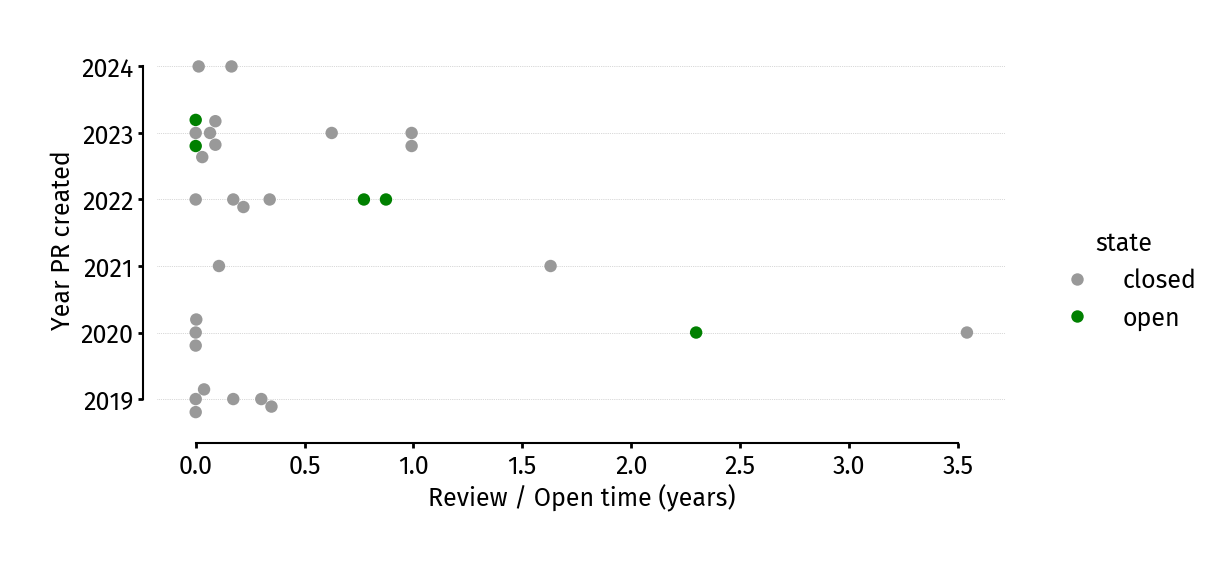

In [19]:
(
    sns.catplot(
        df_times,
        x = 'review_time_years',
        y = 'created_year',
        hue = 'state',
        orient = 'y',
        kind = 'swarm',
        s = 80,
        palette={'closed':'#999999', 'open': 'green',},
        native_scale = True,
        aspect = 2
    )
    .set_xlabels('Review / Open time (years)')
    .set_ylabels('Year PR created')
)
plt.grid(axis='y', ls=':', color='.7', lw=0.5)
sns.despine(trim=True, offset=10)
plt.savefig('figures/staged-ndx-GH-PR-review-time.svg')